# 1 实验介绍
## 1.1 关于本实验
本实验主要介绍MindSpore的进阶用法，比如参数初始化、运行环境配置、数据增强、回调函数等，让学员了解如何用MindSpore进行数据预处理以及搭建复杂神经网络，掌握MindSpore开发的较为完整的流程。
## 1.2 实验目的
* 理解MindSpore开发全流程。
* 理解MindSpore进阶模块的功能。
* 掌握MindSpore的进阶操作。

## 1.3 背景知识
神经网络知识：参数初始化、数据预处理、数据增强、卷积神经网络（卷积层、池化层）、损失函数 
## 1.4 实验设计
1.参数初始化 
2.运行环境配置
3.数据集预处理
4.数据增强
5.进阶神经网络搭建
6.回调函数Callback
7.模型保存与加载
# 2 实验过程
## 2.1 参数初始化
深度学习模型训练需要对参数进行不断更新，因此权重初始化对于模型性能至关重要，好的初始化参数能够加快模型收敛速度，尽可能找到最优解，缓解梯度消失和梯度爆炸的问题。
### 步骤 1	创建并初始化张量
mindspore.common.initializer.initializer


In [34]:
import numpy as np
import mindspore
from mindspore import Tensor
from mindspore.common.initializer import initializer, One
data = Tensor(np.zeros([1, 2, 3]), mindspore.float32)
tensor1 = initializer(data, [1, 2, 3], mindspore.float32)
tensor2 = initializer('ones', [1, 2, 3], mindspore.float32)
tensor3 = initializer(One(), [1, 2, 3], mindspore.float32)
tensor4 = initializer(0, [1, 2, 3], mindspore.float32)
print(data)
print(tensor1)
print(tensor2)
print(tensor3)
print(tensor4)
print(tensor4.shape)

[[[0. 0. 0.]
  [0. 0. 0.]]]
[[[0. 0. 0.]
  [0. 0. 0.]]]
[[[1. 1. 1.]
  [1. 1. 1.]]]
[[[1. 1. 1.]
  [1. 1. 1.]]]
[[[0. 0. 0.]
  [0. 0. 0.]]]
(1, 2, 3)


### 步骤 2	正态分布初始化
用正态分布函数进行初始化。Sigma为正态分布的标准差,mean为均值。

mindspore.common.initializer.Normal(sigma=0.01)


In [35]:
from mindspore.common.initializer import initializer, Normal
tensor11 = initializer(Normal(12,4), [1, 2, 3], mindspore.int32)
tensor12 = initializer('normal', [1, 2, 3], mindspore.float32)
print(tensor11)
print(tensor12)

[[[  7  23  -8]
  [-13   9   3]]]
[[[ 0.00774876 -0.00530165  0.01051994]
  [-0.00591317  0.00090584  0.00918692]]]


## 2.2 运行环境配置
mindspore的context可用于配置当前的执行环境，包括执行模式、执行后端和其他特性切换。
## 步骤 1	设置运行环境
mindspore.context.set_context
* Mode：运行模式为静态图（GRAPH_MODE/0）或动态图（PYNATIVE_MODE/1），默认为动态图；
* device_target：运行设备为 “Ascend”, “GPU”或者 “CPU”，默认为“Ascend”;
* device_id：运行设备ID，默认为0.


In [36]:
from mindspore import context

context.set_context(mode=context.GRAPH_MODE)  # 设置静态图
context.set_context(mode=context.PYNATIVE_MODE)  # 设置动态图
context.set_context(device_target="CPU")  # 设置运行设备为CPU
context.set_context(device_id=0)  # 设置运行设备ID（只对昇腾芯片有效）

## 步骤 2	查看运行环境
mindspore.context.get_context


In [37]:
# 查看运行图模式，0为静态图， 1为动态图
mode = mindspore.context.get_context('mode')  
# 查看运行设备
device_target = mindspore.context.get_context('device_target')

print(mode)
print(device_target)

1
CPU


## 2.3 数据集预处理
数据预处理在众多深度学习算法中都起着重要作用，数据预处理可以提高模型精度，加快模型收敛速度，提升模型性能，这里主要介绍MindSpore常用的数据预处理方式。

数据是深度学习的基础，良好的数据输入可以对整个深度神经网络训练起到非常积极的作用。在训练前对已加载的数据集进行数据处理，可以解决诸如数据量过大、样本分布不均等问题，从而获得更加优化的数据输入。
### 步骤 1	修改数据类型
mindspore.dataset.transforms.c_transforms.TypeCast(data_type)


In [38]:
import mindspore.dataset.transforms.c_transforms as c_transforms
import mindspore.common.dtype as mstype
from mindspore import dataset as ds

dataset_dir = "./data/train"  # 数据集路径，Windows和Linux适用

mnist_dataset = ds.MnistDataset(dataset_dir=dataset_dir, num_samples=3)

# 查看mnist_dataset “label”的数据类型
for x in mnist_dataset.create_dict_iterator():
    print(x['label'].dtype)
print("-----------------------------------")
# 修改mnist_dataset “label”的数据类型为int32 
type_cast_op = c_transforms.TypeCast(mstype.int32)
mnist = mnist_dataset.map(input_columns="label", operations=type_cast_op)

for x in mnist.create_dict_iterator():
    print(x['label'].dtype)

UInt32

[WARNING] ME(3868:19268,MainProcess):2023-05-27-14:06:20.986.328 [mindspore\dataset\core\validator_helpers.py:806] 'TypeCast' from mindspore.dataset.transforms.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'TypeCast' from mindspore.dataset.transforms instead.



UInt32
UInt32
-----------------------------------
Int32
Int32
Int32


### 步骤 2	Shuffle
对数据集进行混洗，随机打乱数据顺序。设定的buffer_size越大，混洗程度越大，但时间、计算资源消耗也会更大。

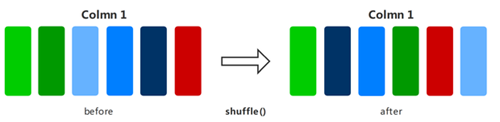

In [39]:
import numpy as np
import mindspore.dataset as ds

ds.config.set_seed(0)

def generator_func():
    for i in range(5):
        yield (np.array([i, i+1, i+2]),)

dataset1 = ds.GeneratorDataset(generator_func, ["data"])
for data in dataset1.create_dict_iterator():
    print(data)
    
print("-----------------------------------")
# shuffle 打乱数据集
dataset2 = dataset1.shuffle(buffer_size=5)
for data in dataset2.create_dict_iterator():
    print(data)

{'data': Tensor(shape=[3], dtype=Int32, value= [0, 1, 2])}
{'data': Tensor(shape=[3], dtype=Int32, value= [1, 2, 3])}
{'data': Tensor(shape=[3], dtype=Int32, value= [2, 3, 4])}
{'data': Tensor(shape=[3], dtype=Int32, value= [3, 4, 5])}
{'data': Tensor(shape=[3], dtype=Int32, value= [4, 5, 6])}
-----------------------------------
{'data': Tensor(shape=[3], dtype=Int32, value= [4, 5, 6])}
{'data': Tensor(shape=[3], dtype=Int32, value= [3, 4, 5])}
{'data': Tensor(shape=[3], dtype=Int32, value= [1, 2, 3])}
{'data': Tensor(shape=[3], dtype=Int32, value= [0, 1, 2])}
{'data': Tensor(shape=[3], dtype=Int32, value= [2, 3, 4])}


### 步骤 3	Map
将指定的函数或算子作用于数据集的指定列数据，实现数据映射操作。用户可以自定义映射函数，也可以直接使用c_transforms或py_transforms中的算子针对图像、文本数据进行数据增强。


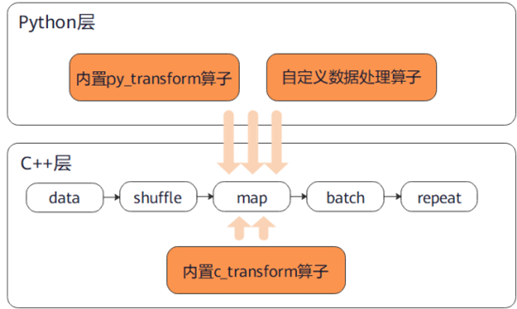

In [40]:
import numpy as np
import mindspore.dataset as ds

def generator_func():
    for i in range(5):
        yield (np.array([i, i+1, i+2]),)

def pyfunc(x):
    return x*2

dataset1 = ds.GeneratorDataset(generator_func, ["data"])

for data in dataset1.create_dict_iterator():
    print(data)

print("------ after processing ------")

dataset2 = dataset1.map(operations=pyfunc, input_columns=["data"])

for data in dataset2.create_dict_iterator():
    print(data)

{'data': Tensor(shape=[3], dtype=Int32, value= [0, 1, 2])}
{'data': Tensor(shape=[3], dtype=Int32, value= [1, 2, 3])}
{'data': Tensor(shape=[3], dtype=Int32, value= [2, 3, 4])}
{'data': Tensor(shape=[3], dtype=Int32, value= [3, 4, 5])}
{'data': Tensor(shape=[3], dtype=Int32, value= [4, 5, 6])}
------ after processing ------
{'data': Tensor(shape=[3], dtype=Int32, value= [0, 2, 4])}
{'data': Tensor(shape=[3], dtype=Int32, value= [2, 4, 6])}
{'data': Tensor(shape=[3], dtype=Int32, value= [4, 6, 8])}
{'data': Tensor(shape=[3], dtype=Int32, value= [ 6,  8, 10])}
{'data': Tensor(shape=[3], dtype=Int32, value= [ 8, 10, 12])}


### 步骤 4	Batch
将数据集分批，分别输入到训练系统中进行训练，可以减少训练轮次，达到加速训练过程的目的。


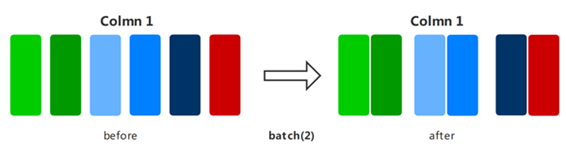

In [41]:
import numpy as np
import mindspore.dataset as ds

def generator_func():
    for i in range(5):
        yield (np.array([i, i+1, i+2]),)

dataset1 = ds.GeneratorDataset(generator_func, ["data"])

dataset1 = dataset1.batch(batch_size=2, drop_remainder=False)
for data in dataset1.create_dict_iterator():
    print(data)

print("------ drop remainder ------")

dataset2 = ds.GeneratorDataset(generator_func, ["data"])

dataset2 = dataset2.batch(batch_size=2, drop_remainder=True)
for data in dataset2.create_dict_iterator():
    print(data)

{'data': Tensor(shape=[2, 3], dtype=Int32, value=
[[0, 1, 2],
 [1, 2, 3]])}
{'data': Tensor(shape=[2, 3], dtype=Int32, value=
[[2, 3, 4],
 [3, 4, 5]])}
{'data': Tensor(shape=[1, 3], dtype=Int32, value=
[[4, 5, 6]])}
------ drop remainder ------
{'data': Tensor(shape=[2, 3], dtype=Int32, value=
[[0, 1, 2],
 [1, 2, 3]])}
{'data': Tensor(shape=[2, 3], dtype=Int32, value=
[[2, 3, 4],
 [3, 4, 5]])}


### 步骤 5	Repeat
对数据集进行重复，达到扩充数据量的目的。repeat和batch操作的顺序会影响训练batch的数量，建议将repeat置于batch之后。


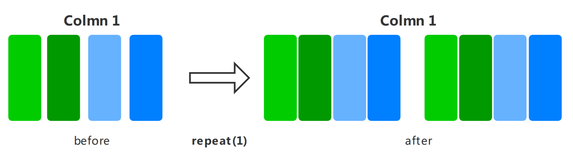

In [42]:
import numpy as np
import mindspore.dataset as ds

def generator_func():
    for i in range(5):
        yield (np.array([i, i+1, i+2]),)

dataset1 = ds.GeneratorDataset(generator_func, ["data"])

dataset1 = dataset1.repeat(count=2)
for data in dataset1.create_dict_iterator():
    print(data)

{'data': Tensor(shape=[3], dtype=Int32, value= [0, 1, 2])}
{'data': Tensor(shape=[3], dtype=Int32, value= [1, 2, 3])}
{'data': Tensor(shape=[3], dtype=Int32, value= [2, 3, 4])}
{'data': Tensor(shape=[3], dtype=Int32, value= [3, 4, 5])}
{'data': Tensor(shape=[3], dtype=Int32, value= [4, 5, 6])}
{'data': Tensor(shape=[3], dtype=Int32, value= [0, 1, 2])}
{'data': Tensor(shape=[3], dtype=Int32, value= [1, 2, 3])}
{'data': Tensor(shape=[3], dtype=Int32, value= [2, 3, 4])}
{'data': Tensor(shape=[3], dtype=Int32, value= [3, 4, 5])}
{'data': Tensor(shape=[3], dtype=Int32, value= [4, 5, 6])}


### 步骤 6	Zip
将两个数据集进行列拼接，合并为一个数据集。如果两个数据集的列名相同，则不会合并，请注意列的命名；如果两个数据集的行数不同，合并后的行数将和较小行数保持一致。


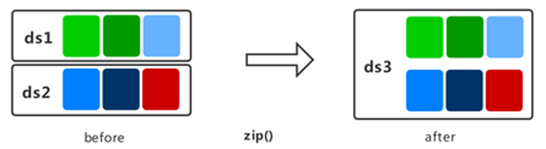

In [43]:
import numpy as np
import mindspore.dataset as ds

def generator_func():
    for i in range(7):
        yield (np.array([i, i+1, i+2]),)

def generator_func2():
    for i in range(4):
        yield (np.array([1, 2]),)

dataset1 = ds.GeneratorDataset(generator_func, ["data1"])
for data in dataset1.create_dict_iterator():
    print(data)
print("-----------------------------------")
dataset2 = ds.GeneratorDataset(generator_func2, ["data2"])
for data in dataset2.create_dict_iterator():
    print(data)
print("-----------------------------------")
dataset3 = ds.zip((dataset1, dataset2))

for data in dataset3.create_dict_iterator():
    print(data)

{'data1': Tensor(shape=[3], dtype=Int32, value= [0, 1, 2])}
{'data1': Tensor(shape=[3], dtype=Int32, value= [1, 2, 3])}
{'data1': Tensor(shape=[3], dtype=Int32, value= [2, 3, 4])}
{'data1': Tensor(shape=[3], dtype=Int32, value= [3, 4, 5])}
{'data1': Tensor(shape=[3], dtype=Int32, value= [4, 5, 6])}
{'data1': Tensor(shape=[3], dtype=Int32, value= [5, 6, 7])}
{'data1': Tensor(shape=[3], dtype=Int32, value= [6, 7, 8])}
-----------------------------------
{'data2': Tensor(shape=[2], dtype=Int32, value= [1, 2])}
{'data2': Tensor(shape=[2], dtype=Int32, value= [1, 2])}
{'data2': Tensor(shape=[2], dtype=Int32, value= [1, 2])}
{'data2': Tensor(shape=[2], dtype=Int32, value= [1, 2])}
-----------------------------------
{'data1': Tensor(shape=[3], dtype=Int32, value= [0, 1, 2]), 'data2': Tensor(shape=[2], dtype=Int32, value= [1, 2])}
{'data1': Tensor(shape=[3], dtype=Int32, value= [1, 2, 3]), 'data2': Tensor(shape=[2], dtype=Int32, value= [1, 2])}
{'data1': Tensor(shape=[3], dtype=Int32, value= 

## 2.4 数据增强
在计算机视觉任务中，数据量过小或是样本场景单一等问题都会影响模型的训练效果，可以通过数据增强操作对图像进行预处理，从而提升模型的泛化性。
### 步骤 1	随机裁剪图片
mindspore.dataset.vision.c_transforms.RandomCrop


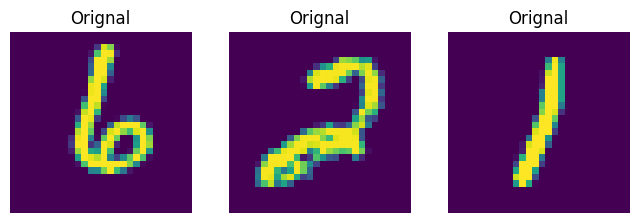

[WARNING] ME(3868:19268,MainProcess):2023-05-27-14:06:21.744.478 [mindspore\dataset\core\validator_helpers.py:806] 'RandomCrop' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'RandomCrop' from mindspore.dataset.vision instead.


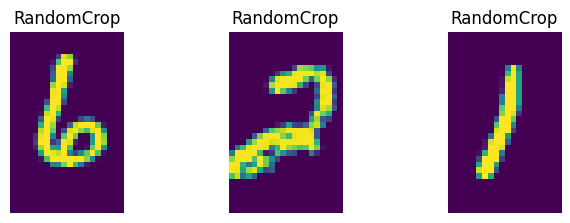

In [44]:
import mindspore.dataset.vision.c_transforms as CV
import matplotlib.pyplot as plt

# 从mnist dataset读取3张图片
mnist_dataset = ds.MnistDataset(dataset_dir=dataset_dir, num_samples=3)

i = 1

# 显示原图
plt.figure(figsize=(8,8))
for dic in mnist_dataset.create_dict_iterator():
    plt.subplot(3,3,i)
    plt.imshow(dic['image'].asnumpy())
    plt.axis('off')
    plt.title('Orignal')
    i +=1

plt.show()

# 随机裁剪：输出大小（32x32）, padding 方式 左上右下。
random_crop_op = CV.RandomCrop([32, 20], [4, 4, 4, 4])
mnist_dataset1 = mnist_dataset.map(operations=random_crop_op, input_columns=["image"])

# 显示随机裁剪后的图片
plt.figure(figsize=(8,8))
for dic in mnist_dataset1.create_dict_iterator(output_numpy=True):
    plt.subplot(3,3,i)
    plt.imshow(dic['image'][:,:,0])
    plt.axis('off')
    plt.title('RandomCrop')
    i +=1

plt.show()

### 步骤 2	调整图片大小
mindspore.dataset.vision.c_transforms.Resize


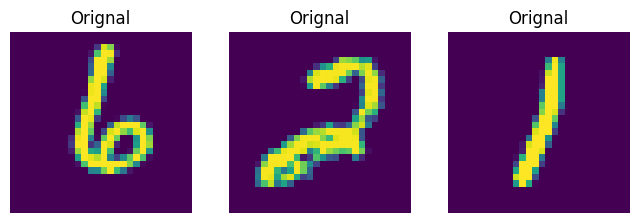

[WARNING] ME(3868:19268,MainProcess):2023-05-27-14:06:22.452.919 [mindspore\dataset\core\validator_helpers.py:806] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.


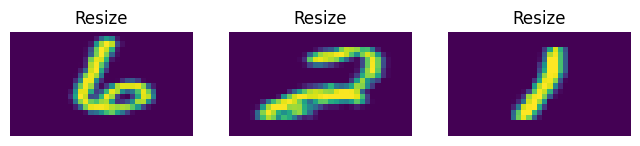

In [45]:
import mindspore.dataset.vision.c_transforms as CV

# 从mnist dataset读取3张图片
mnist_dataset = ds.MnistDataset(dataset_dir=dataset_dir, num_samples=3)

i = 1

# 显示原图
plt.figure(figsize=(8,8))
for dic in mnist_dataset.create_dict_iterator():
    plt.subplot(3,3,i)
    plt.imshow(dic['image'].asnumpy())
    plt.axis('off')
    plt.title('Orignal')
    i +=1

plt.show()

# 调整图像大小
resize = CV.Resize([20, 35])
mnist_dataset1 = mnist_dataset.map(operations=resize, input_columns=["image"])


# 显示调整大小后的图片
plt.figure(figsize=(8,8))
for dic in mnist_dataset1.create_dict_iterator(output_numpy=True):
    plt.subplot(3,3,i)
    plt.imshow(dic['image'][:,:,0])
    plt.axis('off')
    plt.title('Resize')
    i +=1

plt.show()


### 步骤 3	像素值修改
mindspore.dataset.vision.c_transforms.Rescale(rescale, shift)


In [46]:
import mindspore.dataset.vision.c_transforms as CV

# 从mnist dataset读取3张图片
mnist_dataset = ds.MnistDataset(dataset_dir=dataset_dir, num_samples=3)

# 原图像素值
for dic in mnist_dataset.create_dict_iterator(output_numpy=True):
    print("原图像素值:", dic['image'][:,:,0])

# rescale 缩放系数，shift 平移大小，相当于ax+b
rescale = CV.Rescale(rescale=3, shift=100)
mnist_dataset1 = mnist_dataset.map(operations=rescale, input_columns=["image"])

# 修改后的像素值
for dic in mnist_dataset1.create_dict_iterator(output_numpy=True):
    print("修改后的像素值:", dic['image'][:,:,0])

原图像素值: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  42 240 207   7   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  14 183 254 252  32   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  57 254 254 219   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  78 254 254 120   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  87 254 254  80   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 215 255 240  22   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 248 254

[WARNING] ME(3868:19268,MainProcess):2023-05-27-14:06:23.942.616 [mindspore\dataset\core\validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.


修改后的像素值: [[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
  100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
 [100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
  100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
 [100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 226.
  820. 721. 121. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
 [100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 142. 649.
  862. 856. 196. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
 [100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 271. 862.
  862. 757. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
 [100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 334. 862.
  862. 460. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
 [100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 361. 862.
  862. 340. 100. 100. 100. 100. 100. 100. 100. 10

### 步骤 4	图像标准化
mindspore.dataset.vision.py_transforms.Normalize(mean, std)

将输入的NumPy图像数组（形状必须为(C, H, W)）用给定的均值和标准差进行标准化。
数组的值必须在(0, 1]范围内。


In [47]:
import numpy as np
import mindspore.dataset as ds

# 读取图片，decode=TRUE 解码为（H,W,C）的格式
dataset = ds.ImageFolderDataset('./data/cat', decode=True)

# 原图像素值
for x in dataset.create_dict_iterator():
    print("原图像形状:",x['image'].shape) # 高，宽，通道数
    print("原图像素值:",x['image'])
    
# 进行标准化操作    
normalize_op = CV.Normalize(mean=(123.68,116.78,103.94), std=[1, 1, 1])
dataset = dataset.map(operations=normalize_op, input_columns=["image"])

# 标准化之后的像素值
for x in dataset.create_dict_iterator():
    print("标准化之后的像素值:",x['image'])

原图像形状:

[WARNING] ME(3868:19268,MainProcess):2023-05-27-14:06:24.393.163 [mindspore\dataset\core\validator_helpers.py:806] 'Normalize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Normalize' from mindspore.dataset.vision instead.


 (2448, 3264, 3)
原图像素值: [[[131 145 109]
  [131 145 109]
  [132 146 110]
  ...
  [196 185 199]
  [196 185 199]
  [196 185 199]]

 [[132 146 110]
  [132 146 110]
  [133 147 111]
  ...
  [198 187 201]
  [198 187 201]
  [198 187 201]]

 [[132 146 110]
  [133 147 111]
  [135 149 113]
  ...
  [200 189 203]
  [200 189 203]
  [200 189 203]]

 ...

 [[127 131  72]
  [130 134  75]
  [134 140  80]
  ...
  [159 106  52]
  [159 106  52]
  [159 106  52]]

 [[127 131  72]
  [130 134  75]
  [134 140  80]
  ...
  [159 106  52]
  [159 106  52]
  [159 106  52]]

 [[127 131  72]
  [130 134  75]
  [133 139  79]
  ...
  [158 105  51]
  [158 105  51]
  [158 105  51]]]
原图像形状: (1607, 2788, 3)
原图像素值: [[[ 57  69  49]
  [ 55  67  47]
  [ 51  65  42]
  ...
  [ 71  98  67]
  [ 70  97  66]
  [ 70  97  66]]

 [[ 57  69  49]
  [ 55  67  47]
  [ 51  65  42]
  ...
  [ 69  96  65]
  [ 68  95  64]
  [ 68  95  64]]

 [[ 59  71  51]
  [ 57  69  49]
  [ 53  67  44]
  ...
  [ 70  97  66]
  [ 68  95  64]
  [ 68  95  64]]

 ...

### 步骤 5	随机水平翻转图像
mindspore.dataset.vision.c_transforms.RandomHorizontalFlip(prob=0.5)


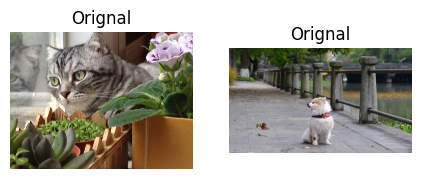

[WARNING] ME(3868:19268,MainProcess):2023-05-27-14:06:26.419.65 [mindspore\dataset\core\validator_helpers.py:806] 'RandomHorizontalFlip' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'RandomHorizontalFlip' from mindspore.dataset.vision instead.


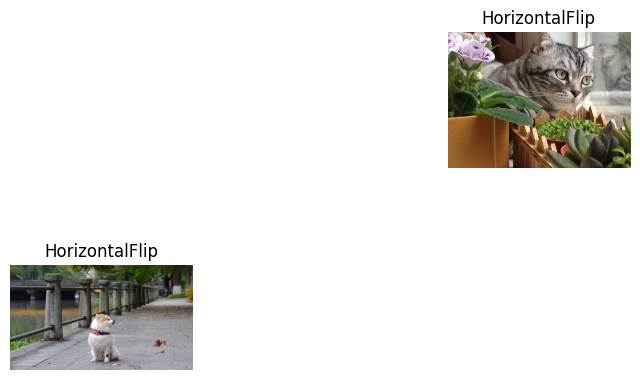

In [48]:
import mindspore.dataset.vision.c_transforms as CV
import numpy as np
import mindspore.dataset as ds

# 读取图片，decode=TRUE 解码为（H,W,C）的格式
dataset1 = ds.ImageFolderDataset('./data/cat', decode= True)

i = 1

# 显示原图
plt.figure(figsize=(8,8))
for dic in dataset1.create_dict_iterator():
    plt.subplot(3,3,i)
    plt.imshow(dic['image'].asnumpy())
    plt.axis('off')
    plt.title("Orignal")
    i +=1

plt.show()

# 水平翻转图片，随机翻转概率为1
RandomHorizontalFlip = CV.RandomHorizontalFlip(1)
dataset = dataset1.map(operations=RandomHorizontalFlip, input_columns=["image"])


# 显示翻转之后的图片
plt.figure(figsize=(8,8))
for dic in dataset.create_dict_iterator():
    plt.subplot(3,3,i)
    plt.imshow(dic['image'].asnumpy())
    plt.axis('off')
    plt.title("HorizontalFlip")
    i +=1

plt.show()

### 步骤 6	转换图像通道
mindspore.dataset.vision.c_transforms.HWC2CHW


In [49]:
import mindspore.dataset.vision.c_transforms as CV
import numpy as np
import mindspore.dataset as ds

# 读取图片，decode=TRUE 解码为（H,W,C）的格式
dataset = ds.ImageFolderDataset('./data/cat', decode= True)

# 原图shape
for x in dataset.create_dict_iterator():
    print("原图形状：", x['image'].shape) 

# 转置输入图像从形状(H, W, C)到形状(C, H, W)
HWC2CHW = CV.HWC2CHW()
dataset1 = dataset.map(operations=HWC2CHW, input_columns=["image"])

# 通道转换之后的shape
for x in dataset1.create_dict_iterator():
    print("通道转换之后的形状：",x['image'].shape) 

[WARNING] ME(3868:19268,MainProcess):2023-05-27-14:06:27.343.060 [mindspore\dataset\core\validator_helpers.py:806] 'HWC2CHW' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'HWC2CHW' from mindspore.dataset.vision instead.


原图形状： (2448, 3264, 3)
原图形状： (1607, 2788, 3)
通道转换之后的形状： (3, 2448, 3264)
通道转换之后的形状： (3, 1607, 2788)


## 2.5 进阶神经网络搭建
### 步骤 1	卷积神经网络
卷积层

mindspore.nn.Conv2d
* in_channels：输入通道
* out_channels：输出通道
* kernel_size ：核大小
* stride ：步长
* pad_mode ：padding方式（“same”, “valid”, “pad”）. Default: “same”.
* Padding：padding补齐数字
* has_bias：是否有偏置项Default: False.
* weight_init： 权重初始化 Default: ‘normal’.
* bias_init：偏置项初始化Default: ‘zeros’.
* data_format：数据形状（ ‘NHWC’ or ‘NCHW’ ）. Default: ‘NCHW’


In [50]:
import mindspore
import mindspore.nn as nn
from mindspore import Tensor

# mindspore.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, pad_mode='same', padding=0, dilation=1, 
#                     group=1, has_bias=False, weight_init='normal', bias_init='zeros', data_format='NCHW')

# 图片数，通道数，图像高，图像宽
input = Tensor(np.ones([1, 3, 1080, 960]), mindspore.float32) 

# 输入通道数为3，输出通道数为24， 卷积核大小为5， 步长为1，padding方式same，有偏置项，权重初始化为normal
net = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=5, stride=1, pad_mode='same', has_bias=True, weight_init='normal')

# 图片数，通道数，图像高，图像宽
output = net(input).shape
print(output)

(1, 24, 1080, 960)


### 步骤 2	激活函数
矫正线性单元激活函数

mindspore.nn.ReLU


In [51]:
input_x = Tensor(np.array([-1, 2, -3, 2, -1]), mindspore.float16)

relu = nn.ReLU()
output = relu(input_x)
print(output)

[0. 2. 0. 2. 0.]


### 步骤 3	池化层
2维数据最大池化

mindspore.nn.MaxPool2d
* kernel_size ：池化大小 Default: 1.
* Stride ：池化步长 Default: 1.
* pad_mode：padding方式（“same” or “valid”）. Default: “valid”.
* data_format：数据形式（‘NHWC’ or ‘NCHW’ ）. Default: ‘NCHW’


In [52]:
input_x = np.random.randint(0, 10, [1, 2, 4, 4])
print(input_x)
print("-----------------------------------")

# 最大池化，池化大小2x2， 步长为2
pool = nn.MaxPool2d(kernel_size=2, stride=2)

output = pool(Tensor(input_x, mindspore.float32))  
print(output)

[[[[5 0 3 3]
   [7 9 3 5]
   [2 4 7 6]
   [8 8 1 6]]

  [[7 7 8 1]
   [5 9 8 9]
   [4 3 0 3]
   [5 0 2 3]]]]
-----------------------------------
[[[[9. 5.]
   [8. 7.]]

  [[9. 9.]
   [5. 3.]]]]


### 步骤 4	Flatten层
mindspore.nn.Flatten

Flatten层可以把多维的输入一维化，常用在卷积层到全连接层的过渡。


In [53]:
from mindspore import Tensor
import mindspore
import mindspore.nn as nn

input = Tensor(np.array([[[1, 1], [2, 2]], [[3, 3], [4, 4]]]), mindspore.float32)
print(input)
print("-----------------------------------")

net = nn.Flatten()
output = net(input)
print(output) 

[[[1. 1.]
  [2. 2.]]

 [[3. 3.]
  [4. 4.]]]
-----------------------------------
[[1. 1. 2. 2.]
 [3. 3. 4. 4.]]


### 步骤 5	全连接层
全连接层

mindspore.nn.Dense
* in_channels：输入通道
* out_channels：输出通道
* weight_init：权重初始化，Default 'normal'.


In [54]:
import mindspore.nn as nn
from mindspore import Tensor

# 构造输入张量
input = Tensor(np.array([[1, 1, 1], [2, 2, 2]]), mindspore.float32)
print(input)
print("-----------------------------------")

# 构造全连接网络，输入通道为3，输出通道为3
net = nn.Dense(in_channels=3, out_channels=3, weight_init=1)
output = net(input)
print(output) 

[[1. 1. 1.]
 [2. 2. 2.]]
-----------------------------------
[[3. 3. 3.]
 [6. 6. 6.]]


### 步骤 6	搭建卷积神经网络模型
所有神经网络的基类

mindspore.nn.Cell


In [55]:
import mindspore.nn as nn

class MyCell(nn.Cell):
    
    # 定义算子
    def __init__(self, ):
        super(MyCell, self).__init__()
        # 卷积层
        self.conv = nn.Conv2d()
         
        # 激活函数
        self.relu = nn.ReLU()
        
        # 最大池化层
        self.max_pool2d = nn.MaxPool2d()
        
        # 网络展开
        self.flatten = nn.Flatten()        
        
        # 全连接层
        self.fc = nn.Dense()


    # 建构网络
    def construct(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

## 2.6 回调函数Callback
Callback回调函数在MindSpore中被实现为一个类，Callback机制类似于一种监控模式，可以帮助用户观察网络训练过程中各种参数的变化情况和网络内部的状态，还可以根据用户的指定，在达到特定条件后执行相应的操作，在训练过程中，Callback列表会按照定义的顺序执行Callback函数。Callback机制让用户可以及时有效地掌握网络模型的训练状态，并根据需要随时作出调整，可以极大地提升用户的开发效率。

### 步骤 1	ModelCheckpoint
与模型训练过程相结合，保存训练后的模型和网络参数，方便进行再推理或再训练。ModelCheckpoint一般与CheckpointConfig配合使用，CheckpointConfig是一个参数配置类，可自定义配置checkpoint的保存策略。

mindspore.train.callback.ModelCheckpoint
* prefix：保存文件名称，默认'CKP'； 
* directory：保存文件路径，默认None；

mindspore.train.callback.CheckpointConfig
* save_checkpoint_steps：每多少步（step）保存一次模型，默认为1； 
* keep_checkpoint_max：最多保存多少个模型, 默认为5；



In [56]:
from mindspore.train.callback import ModelCheckpoint,CheckpointConfig


# 检查点设置，这里设定每5个step保存一次，最多保存1个次
config_ck = CheckpointConfig(save_checkpoint_steps=5,
                             keep_checkpoint_max=1)
# 模型保存，定义保存文件名以及路径
ckpoint_cb = ModelCheckpoint(prefix='CKP', directory='./', config=config_ck) # directory是传入参数

### 步骤 2	LossMonitor
监控训练过程中的loss变化情况，当loss为NAN或INF时，提前终止训练。可以在日志中输出loss，方便用户查看。

mindspore.train.callback.LossMonitor(per_print_times=1)
* per_print_times：每多少步（step）打印一次损失值


In [57]:
from mindspore.train.callback import LossMonitor

# 每500步打印一次损失值
loss_cb = LossMonitor(per_print_times=500)

### 步骤 3	TimeMonitor
监控训练过程中每个epoch，每个step的运行时间。

mindspore.train.callback.TimeMonitor(data_size=None)
* data_size：数据集大小


In [58]:
from mindspore.train.callback import TimeMonitor

# 监控每次迭代的时间
# time_cb = TimeMonitor(data_size=data_train.get_dataset_size())  # data_train.get_dataset_size()是传入参数

### 步骤 4	MindSpore自定义回调函数
当用户有自己的特殊需求时，可以基于Callback基类，自定义满足用户自身需求的回调函数。Callback可以把训练过程中的重要信息记录下来，通过一个字典类型变量cb_params传递给Callback对象， 用户可以在各个自定义的Callback中获取到相关属性，执行自定义操作。

以下面两个场景为例，介绍自定义Callback回调函数的功能：
* 实现记录模型训练过程中的评估指标，用户可以在训练过程中，在每个epoch结束时，记录模型评估指标的变化。


In [59]:
from mindspore.train.callback import Callback

# 记录模型每个epoch的loss
class TrainHistroy(Callback):
    """
    记录模型训练时每个epoch的loss的回调函数

    Args:
        history (list): 传入list以保存模型每个epoch的loss
    """
    
    def __init__(self, history):
        super(TrainHistroy, self).__init__()
        self.history = history
        
    # 每个epoch结束时执行
    def epoch_end(self, run_context):
        cb_params = run_context.original_args()
        loss = cb_params.net_outputs.asnumpy()
        self.history.append(loss)

# 记录每次迭代的模型损失值
# train_hist_cb = TrainHistroy(hist['loss'])

* 实现保存训练过程中精度最高的checkpoint文件，用户可以自定义在每一轮迭代后都保存当前精度最高的模型。

In [60]:
# 测试并记录模型在测试集的loss和accuracy，每个epoch结束时进行模型测试并记录结果，跟踪并保存准确率最高的模型网络参数
class EvalHistory(Callback):
    """
    记录模型训练时每个epoch在测试集的loss和accuracy的回调函数，并保存准确率最高的模型网络参数

    Args:
        model (Cell): 模型，评估loss和accuracy用
        loss_history (list): 传入list以保存模型每个epoch在测试集的loss
        acc_history (list): 传入list以保存模型每个epoch在测试集的accuracy
        eval_data (Dataset): 测试集，评估模型loss和accuracy用
    """
    
    #保存accuracy最高的网络参数
    best_param = None
    
    def __init__(self, model, loss_history, acc_history, eval_data):
        super(EvalHistory, self).__init__()
        self.loss_history = loss_history
        self.acc_history = acc_history
        self.eval_data = eval_data
        self.model = model
    
    # 每个epoch结束时执行
    def epoch_end(self, run_context):
        cb_params = run_context.original_args()
        res = self.model.eval(self.eval_data, dataset_sink_mode=False)
        
        if len(self.acc_history)==0 or res['accuracy']>=max(self.acc_history):
            self.best_param = copy.deepcopy(cb_params.network)
            
        self.loss_history.append(res['loss'])
        self.acc_history.append(res['accuracy'])
        
        print('acc_eval: ',res['accuracy'])
    
    # 训练结束后执行
    def end(self, run_context):
        # 保存最优网络参数
        best_param_path = os.path.join(ckpt_path, 'best_param.ckpt')
        
        if os.path.exists(best_param_path):
            # best_param.ckpt已存在时MindSpore会覆盖旧的文件，这里修改文件读写权限防止报错
            os.chmod(best_param_path, stat.S_IWRITE)
            
        save_checkpoint(self.best_param, best_param_path)

# 测试并记录模型在验证集的loss和accuracy，并保存最优网络参数
# eval_hist_cb = EvalHistory(model = model,
#                            loss_history = hist['loss_eval'], 
#                            acc_history = hist['acc_eval'], 
#                            eval_data = test_data)

## 2.7 模型保存与加载
在模型训练过程中，可以添加检查点(CheckPoint)用于保存模型的参数，以便执行推理及再训练使用。如果想继续在不同硬件平台上做推理，可通过网络和CheckPoint格式文件生成对应的MindIR、AIR和ONNX格式文件。

* MindIR：MindSpore的一种基于图表示的函数式IR，定义了可扩展的图结构以及算子的IR表示，它消除了不同后端的模型差异。可以把在Ascend 910训练好的模型，在Ascend 310和MindSpore Lite端侧上执行推理。
* ONNX：全称Open Neural Network Exchange，是一种针对机器学习所设计的开放式的文件格式，用于存储训练好的模型。

我们已在回调函数的ModelCheckpoint中介绍了如何保存CheckPoint格式文件，接下来我们将介绍导出MindIR和ONNX格式文件的方法。
### 步骤 1	导出MindIR格式文件
如果想跨平台或硬件执行推理(Lite、Ascend 310)，可以通过网络定义和CheckPoint生成MindIR格式模型文件。当前支持基于静态图，且不包含控制流语义的推理网络导出。
* input用来指定导出模型的输入shape以及数据类型，input为export方法的入参，代表网络的输入，如果网络有多个输入，需要一同传进export方法。 例如：export(network, Tensor(input1), Tensor(input2), file_name='network', file_format='MINDIR')
* 导出的文件名称会自动添加”.mindir”后缀。


In [61]:
import numpy as np
from mindspore import Tensor, export, load_checkpoint, load_param_into_net

# resnet = ResNet50()
# # load the parameter into net
# load_checkpoint("resnet50-2_32.ckpt", net=resnet)
# input = np.random.uniform(0.0, 1.0, size=[32, 3, 224, 224]).astype(np.float32)
# export(resnet, Tensor(input), file_name='resnet50-2_32', file_format='MINDIR')

### 步骤 2	导出ONNX格式文件
当有了CheckPoint文件后，如果想继续在昇腾AI处理器、GPU、CPU等多种硬件上做推理，需要通过网络和CheckPoint生成对应的ONNX格式模型文件。
* input用来指定导出模型的输入shape以及数据类型，input为export方法的入参，代表网络的输入，如果网络有多个输入，需要一同传进export方法。 例如：export(network, Tensor(input1), Tensor(input2), file_name='network', file_format='ONNX')
* 导出的文件名称会自动添加”.onnx”后缀。
* 目前ONNX格式导出仅支持ResNet系列网络。


In [62]:
import numpy as np
from mindspore import Tensor, export, load_checkpoint, load_param_into_net

# resnet = ResNet50()
# # load the parameter into net
# load_checkpoint("resnet50-2_32.ckpt", net=resnet)
# input = np.random.uniform(0.0, 1.0, size=[32, 3, 224, 224]).astype(np.float32)
# export(resnet, Tensor(input), file_name='resnet50-2_32', file_format='ONNX') 

### 步骤 3	模型加载
针对仅推理场景可以使用load_checkpoint把参数直接加载到网络中，以便进行后续的推理验证。
* load_checkpoint方法会把参数文件中的网络参数加载到模型中。加载后，网络中的参数就是CheckPoint保存的。
* eval方法会验证训练后模型的精度。


In [63]:
# resnet = ResNet50()
# load_checkpoint("resnet50-2_32.ckpt", net=resnet)
# dateset_eval = create_dataset(os.path.join(mnist_path, "test"), 32, 1) # define the test dataset
# loss = CrossEntropyLoss()
# model = Model(resnet, loss, metrics={"accuracy"})
# acc = model.eval(dataset_eval) 

# 3 实验总结
本实验介绍了MindSpore的参数初始化方法，运行环境配置，数据集预处理和数据增强，以及卷积神经网络的搭建，如何设置回调函数Callback，模型的保存与加载等，让学生全面掌握MindSpore的开发流程，熟悉MindSpore的进阶用法，能够使用MindSPore搭建并训练复杂神经网络，为后续实验打下良好基础。

